In [1]:
import keras
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import random
import os
from sklearn.metrics import log_loss
import keras
from keras import models
from keras import layers

d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']


In [2]:
y = train.pop('credit')
def simple_pp(train, test):
    
    # Married, Civil marriage
    train['income_per_size'] = np.log(train['income_total']/train['family_size'])
    test['income_per_size'] = np.log(test['income_total']/test['family_size'])
    train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
    = train['income_per_size'] * 2
    test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
    = test['income_per_size'] * 2
    
    train['gender'] =train['gender'].apply(lambda x: int(x=='F'))
    test['gender'] =test['gender'].apply(lambda x: int(x=='F'))
    
    
    def simple_marry(x):
        if x == 'Married' or x =='Civil marriage':
            return '0'
        elif x == 'Separated' or x == 'Widow':
            return '1'
        else:
            return '2'

    for df in [train,test]:
        df['family_bins'] = df['family_type'].apply(simple_marry)

    # car와 reality를 합친 새로운 칼럼 careality
    train['car'] =train['car'].apply(lambda x: int(x=='Y'))
    train['reality'] =train['reality'].apply(lambda x: int(x=='Y'))
    test['car'] =test['car'].apply(lambda x: int(x=='Y'))
    test['reality'] =test['reality'].apply(lambda x: int(x=='Y'))

    train['careality'] = train['car'] + train['reality']
    train = train.drop(['car', 'reality'],1)

    test['careality'] = test['car'] + test['reality']
    test = test.drop(['car', 'reality'],1)



    object_col = []
    for col in train.columns:
        if train[col].dtype == 'object':
            object_col.append(col)

    enc = OneHotEncoder()
    enc.fit(train.loc[:,object_col])


    train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    train.drop(object_col, axis=1, inplace=True)
    train = pd.concat([train, train_onehot_df], axis=1)

    test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    test.drop(object_col, axis=1, inplace=True)
    test = pd.concat([test, test_onehot_df], axis=1)

    ## 제곱
    for df in [train,test]:
        df['income_per_size'] = df['income_per_size'].apply(lambda x: x**2)
    
    return train,test
X, test = simple_pp(train,test)

In [3]:
import keras
from keras import models
from keras import layers


def nn(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dense(8,activation='relu'))
    model.add(layers.Dense(3,activation='softmax'))

    model.compile(optimizer='rmsprop',
                     loss='sparse_categorical_crossentropy',
                     metrics=['acc'])
    return model

In [4]:
import keras
es = keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy',patience=50)

In [5]:
kf = KFold(n_splits=10, shuffle=False)
skf = StratifiedKFold(n_splits=5, shuffle=False)
hists = {}
for i, (train_idx, valid_idx) in enumerate(skf.split(X,y)):    
#     X_train= X.iloc[train_idx,:]
    model = nn(56)
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_valid = X.iloc[valid_idx,:], y[valid_idx]
    
    history = model.fit(x = X_train, 
                    y = y_train,
                   epochs=1,
#                    batch_size=24576,
                    batch_size=98304,
                   validation_data =(X_valid, y_valid),
                       verbose=100,
                       callbacks=[es])
    hists[i] = model


Train on 21165 samples, validate on 5292 samples
Epoch 1/1
Train on 21165 samples, validate on 5292 samples
Epoch 1/1
Train on 21166 samples, validate on 5291 samples
Epoch 1/1
Train on 21166 samples, validate on 5291 samples
Epoch 1/1
Train on 21166 samples, validate on 5291 samples
Epoch 1/1


In [10]:
dir(hists[0])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_add_unique_metric_name',
 '_base_init',
 '_build_input_shape',
 '_built',
 '_cache_output_metric_attributes',
 '_check_trainable_weights_consistency',
 '_collected_trainable_weights',
 '_compile_metric_functions',
 '_compile_metrics',
 '_compile_weighted_metrics',
 '_compute_previous_mask',
 '_expects_training_arg',
 '_feed_input_names',
 '_feed_input_shapes',
 '_feed_inputs',
 '_feed_loss_fns',
 '_feed_output_names',
 '_feed_output_shapes',
 '_feed_outputs',
 '_feed_sample_weight_modes',
 '_feed_sample_weights',
 '_feed_targets',
 '_function_kwargs',


In [6]:
def return_plot(i):
    
    val_ent = hists[i].history.history['val_loss']
    trn_ent = hists[i].history.history['loss']
    
    val_acc = hists[i].history.history['val_acc']
    trn_acc = hists[i].history.history['acc']
    
    epochs = range(1,len(val_ent)+1)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
#     ax1 = plt.subplot(121)
    sns.lineplot(x=epochs, y=val_ent,ax=ax[0])
    sns.lineplot(x=epochs, y=trn_ent,ax=ax[0])
    
#     ax2 = plt.subplot(122)
    sns.lineplot(x=epochs, y=val_ent,ax=ax[1])
    sns.lineplot(x=epochs, y=trn_ent,ax=ax[1])
    
    plt.show()

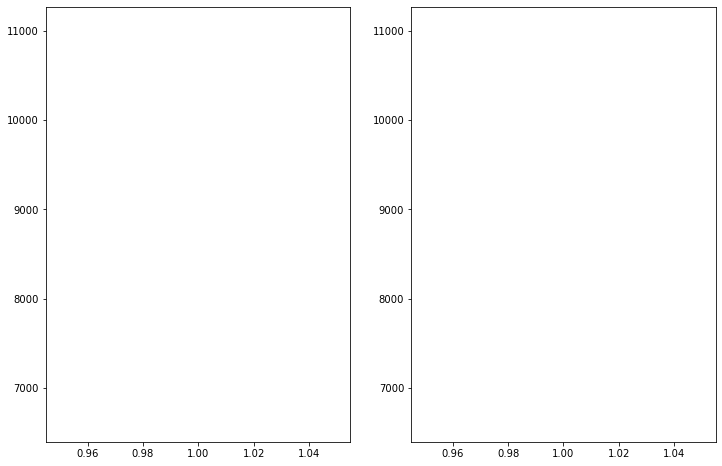

In [7]:
return_plot(1)

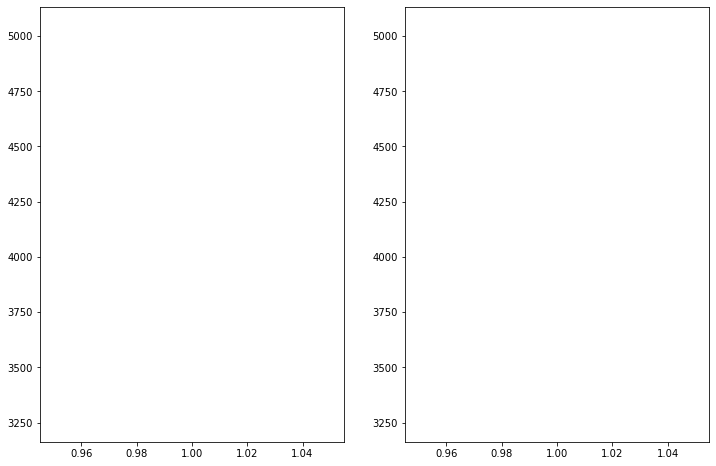

In [8]:
return_plot(2)

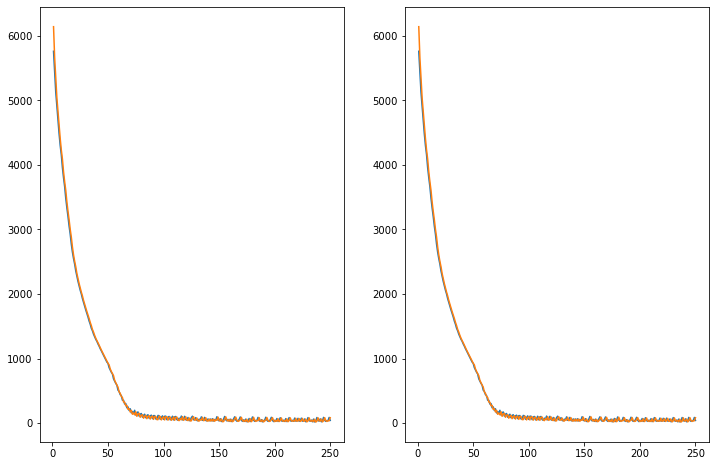

In [73]:
return_plot(3)

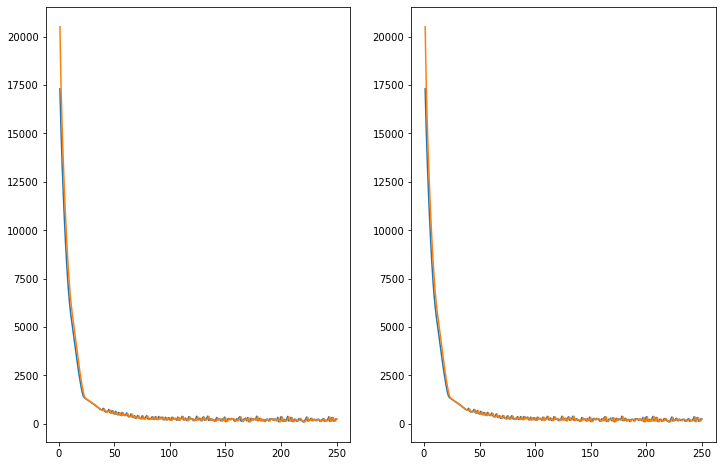

In [74]:
return_plot(4)

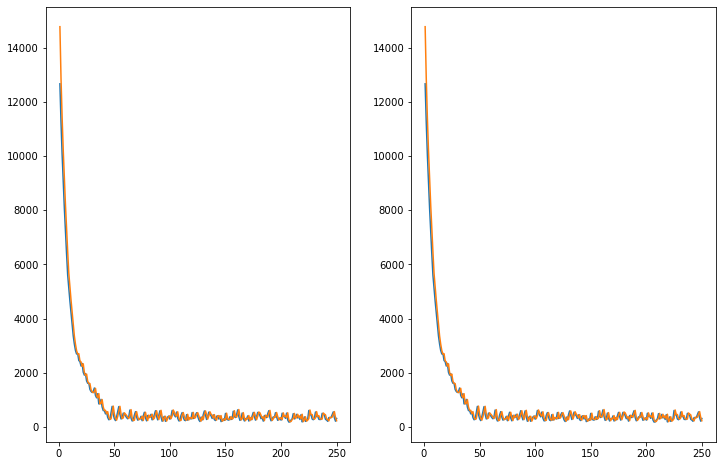

In [75]:
return_plot(0)